<a href="https://colab.research.google.com/github/kavehkarimadini/ARC_101_Tensorflow_Zero2Hero/blob/main/ARC_101_vae_fashion_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👖 Variational Autoencoders - Fashion-MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

The code has been adapted from the excellent [VAE tutorial](https://keras.io/examples/generative/vae/) created by Francois Chollet, available on the Keras website.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

# from notebooks.utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

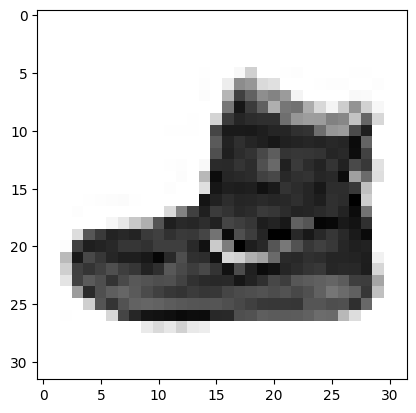

In [6]:
# Show some items of clothing from the training set
plt.imshow(x_train[0], cmap="Greys")
plt.show()

## 2. Build the variational autoencoder <a name="build"></a>

class Sampling(layers.Layer):: This line defines a new class named Sampling that inherits from layers.Layer. This means it's a custom layer you can use in your Keras models.

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        """
        z_mean, z_log_var = inputs: This line unpacks the inputs into two variables:
        z_mean (the mean of the latent distribution) and
        z_log_var (the logarithm of the variance of the latent distribution).
        These are typically outputs from the encoder part of the VAE.
        """
        z_mean, z_log_var = inputs
        """
        batch = tf.shape(z_mean)[0]: Get the batch size from the shape of z_mean.
        dim = tf.shape(z_mean)[1]: Get the dimensionality of the latent space from the shape of z_mean
        """
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        #  This line generates random noise from a standard normal distribution.
        # This noise is crucial for the VAE's ability to generate new data.
        epsilon = K.random_normal(shape=(batch, dim))
        # This line calculates the latent space representation (z) by sampling from the distribution defined
        # by z_mean and z_log_var, using the reparameterization trick.
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        """
        super(VAE, self).__init__(**kwargs): This line calls the constructor of the parent class
        (models.Model) to initialize the basic model properties.
        It passes any additional keyword arguments to the parent constructor.
        """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # self.total_loss_tracker = metrics.Mean(name="total_loss"): This line creates a
        #  Mean metric object to track the total loss during training.
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        # This line creates a Mean metric object to track the reconstruction loss during training.
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        # This line creates a Mean metric object to track the Kullback-Leibler (KL) divergence loss during training.
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
    """
    @property: This is a decorator in Python.
    It's used to define a method that acts like an attribute.
    This means you can access it like an attribute (e.g., vae.metrics) instead of calling it
    as a method (e.g., vae.metrics())
    """
    @property
    def metrics(self):
        # When you access vae.metrics, this code returns a list of the metric objects that
        # are being tracked during training:
        # total loss, reconstruction loss, and KL divergence loss.
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        # This line creates a gradient tape context.
        # Gradient tapes are used in TensorFlow to record operations for automatic differentiation,
        # which is essential for calculating gradients during training.
        with tf.GradientTape() as tape:
            # self(data) returns the call function outputs
            z_mean, z_log_var, reconstruction = self(data)
            #  This line calculates the reconstruction loss and takes the mean across
            #  all examples in the batch.
            reconstruction_loss = tf.reduce_mean(
                # he reconstruction loss is scaled by a hyperparameter BETA.
                # This controls the balance between reconstruction accuracy and the KL divergence loss.
                BETA
                * losses.binary_crossentropy(
                    # axis=(1, 2, 3): This specifies that the mean should be taken over the
                    # height, width, and channel dimensions of the images.
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            #  This part calculates the sum of the KL divergence
            #  for each latent dimension for each example in the batch.
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
        #  This line calculates the gradients of the total loss with respect to
        # the trainable weights of the VAE model.
        # This is where the gradient tape (tape) that was created earlier is used to perform automatic differentiation.
        grads = tape.gradient(total_loss, self.trainable_weights)
        # This line applies the calculated gradients to the model's weights using the optimizer.
        # This step updates the model's weights to minimize the total loss.
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # This line creates a dictionary where the keys are the names of the metrics
        #  (e.g., "total_loss") and the values are the current results of the metric trackers.
        # This dictionary is returned to provide information about the training progress
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        # if isinstance(data, tuple):
        #     data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [12]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [13]:
# Compile the variational autoencoder
opt = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=opt)

In [14]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=x_test,
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 223s 365ms/step - kl_loss: 3.5838 - reconstruction_loss: 198.3392 - total_loss: 201.9230 - val_kl_loss: 4.7794 - val_loss: 144.6228 - val_reconstruction_loss: 139.8434
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 259s 361ms/step - kl_loss: 4.8014 - reconstruction_loss: 133.7264 - total_loss: 138.5278 - val_kl_loss: 4.9750 - val_loss: 141.5709 - val_reconstruction_loss: 136.5959
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 263s 362ms/step - kl_loss: 4.8506 - reconstruction_loss: 131.3119 - total_loss: 136.1625 - val_kl_loss: 4.9054 - val_loss: 141.3504 - val_reconstruction_loss: 136.4450
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 217s 362ms/step - kl_loss: 4.9009 - reconstruction_loss: 130.1008 - total_loss: 135.0017 - val_kl_loss: 5.1950 - val_loss: 139.4709 - val_reconstruction_loss: 134.2759
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 263s 365ms/step - kl_loss: 4.9961 - reconstruction_loss: 129.2651 - total_loss: 134.2612 - val_kl_loss: 5.0864 - val_loss: 138.9029 -

In [ ]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [15]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [17]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step


Example real clothing items


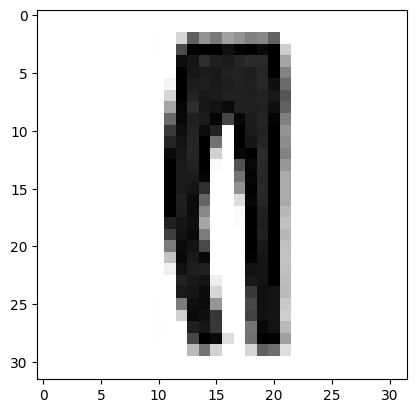

Reconstructions


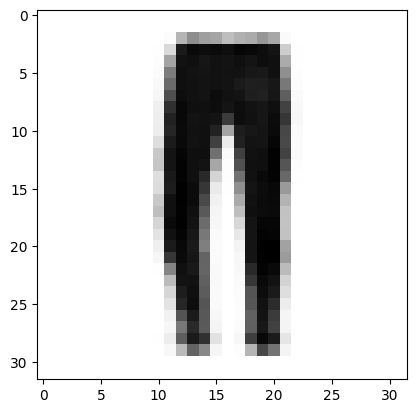

In [19]:
print("Example real clothing items")
plt.imshow(example_images[2], cmap="Greys")
plt.show()
print("Reconstructions")
plt.imshow(reconstructions[2], cmap="Greys")

## 4. Embed using the encoder <a name="encode"></a>

In [20]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [21]:
# Some examples of the embeddings
print(z[:10])

[[-2.0436585   0.16656688]
 [ 0.1463725  -1.0901115 ]
 [ 2.4301333  -0.31397802]
 [ 1.9529872   1.0563799 ]
 [-0.01000933 -0.0989442 ]
 [ 1.7679741  -0.5381489 ]
 [ 0.384049    0.9193423 ]
 [ 0.18085438  0.49900657]
 [-0.68093324  2.6730964 ]
 [-0.9807219   1.5334518 ]]


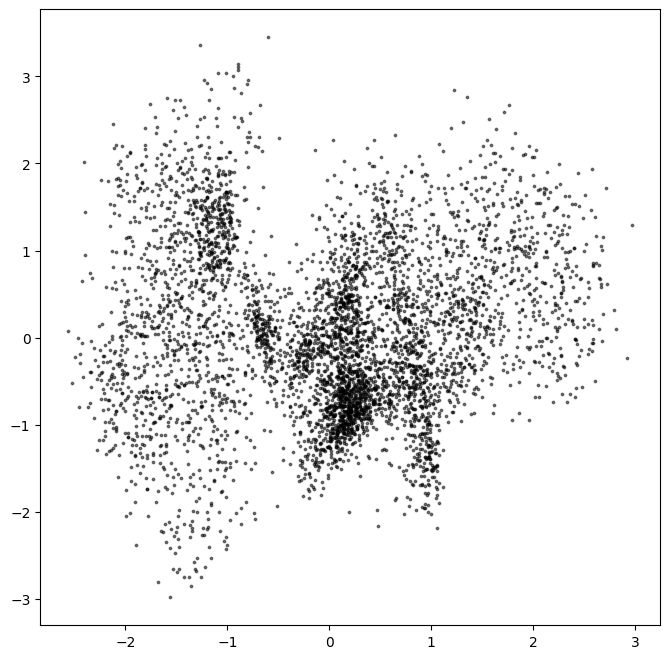

In [22]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [23]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [24]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [25]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

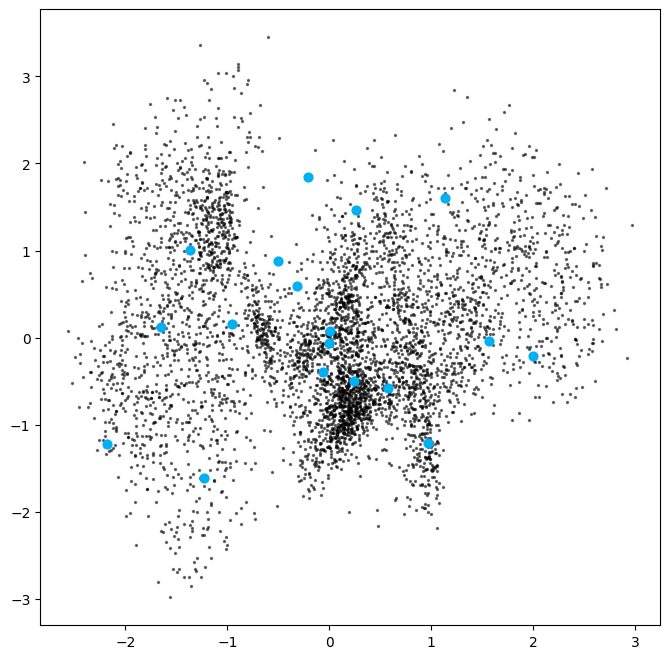

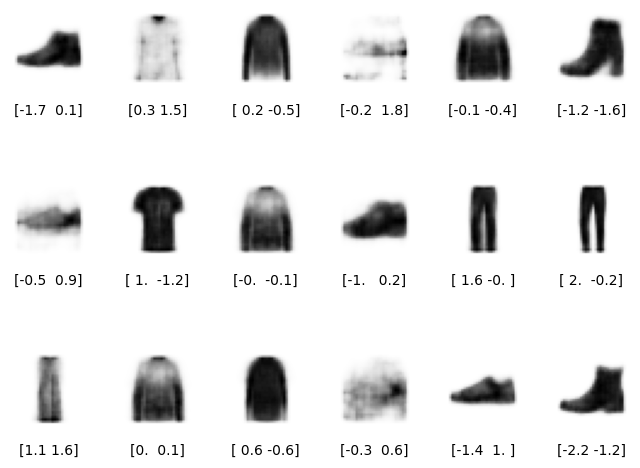

In [26]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

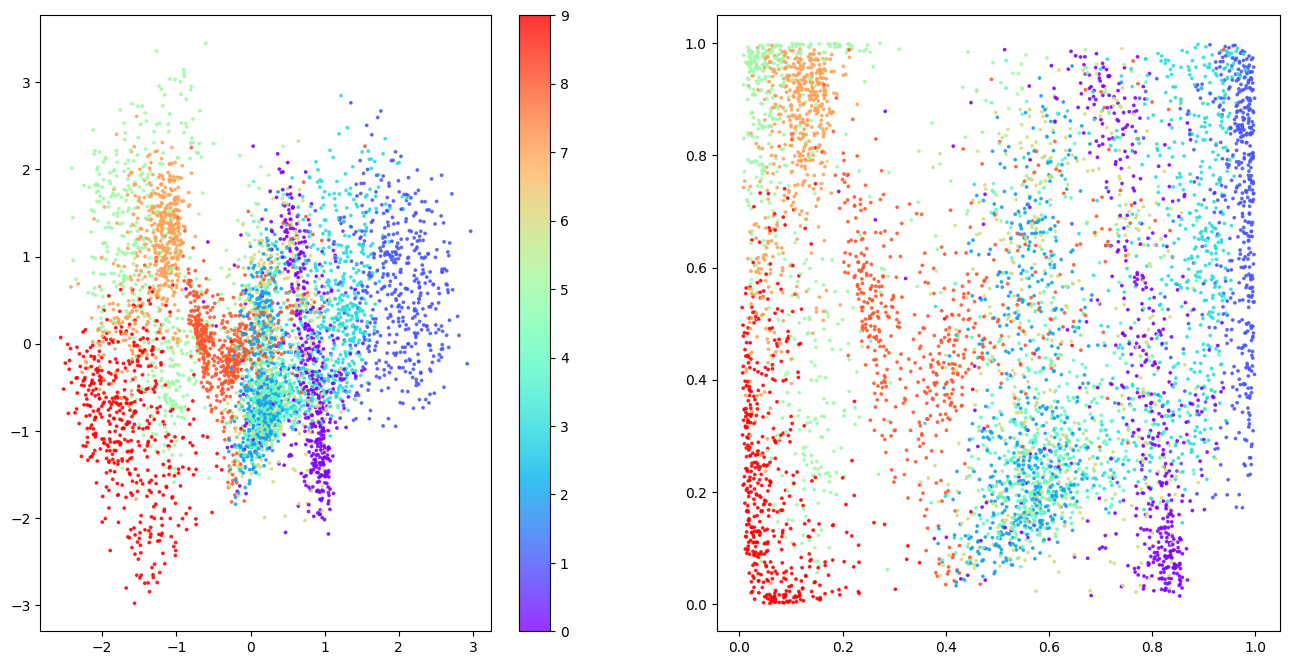

In [27]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


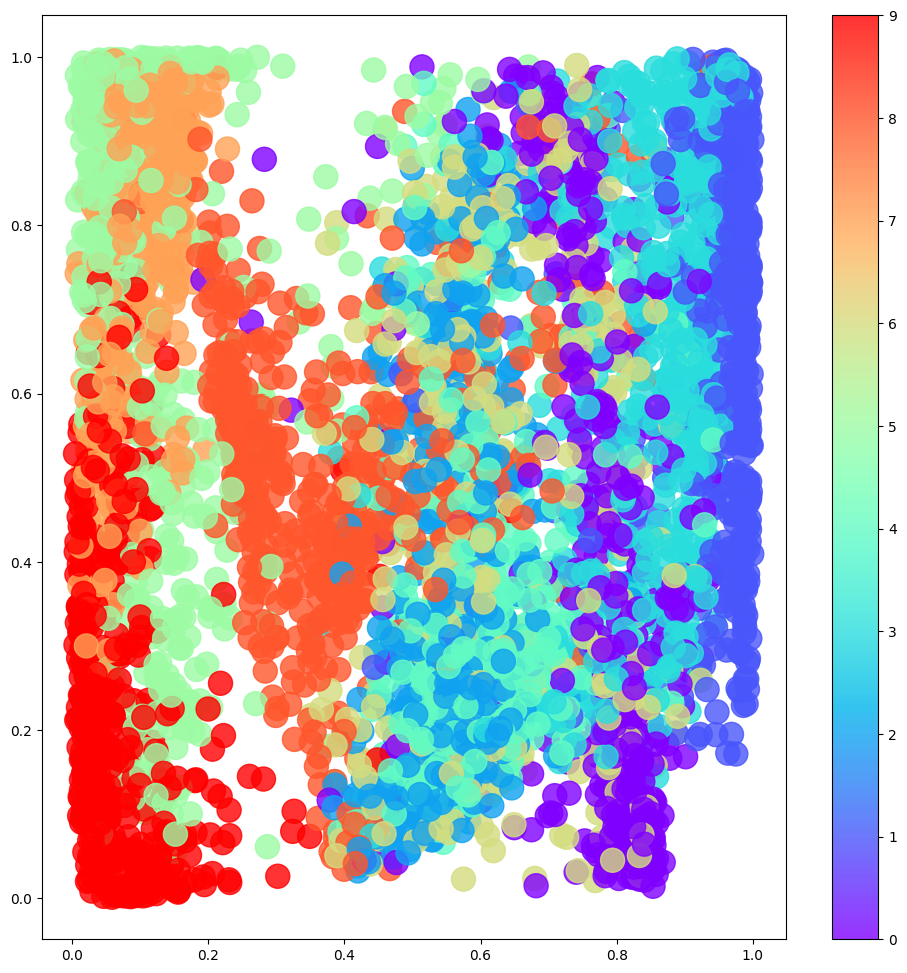

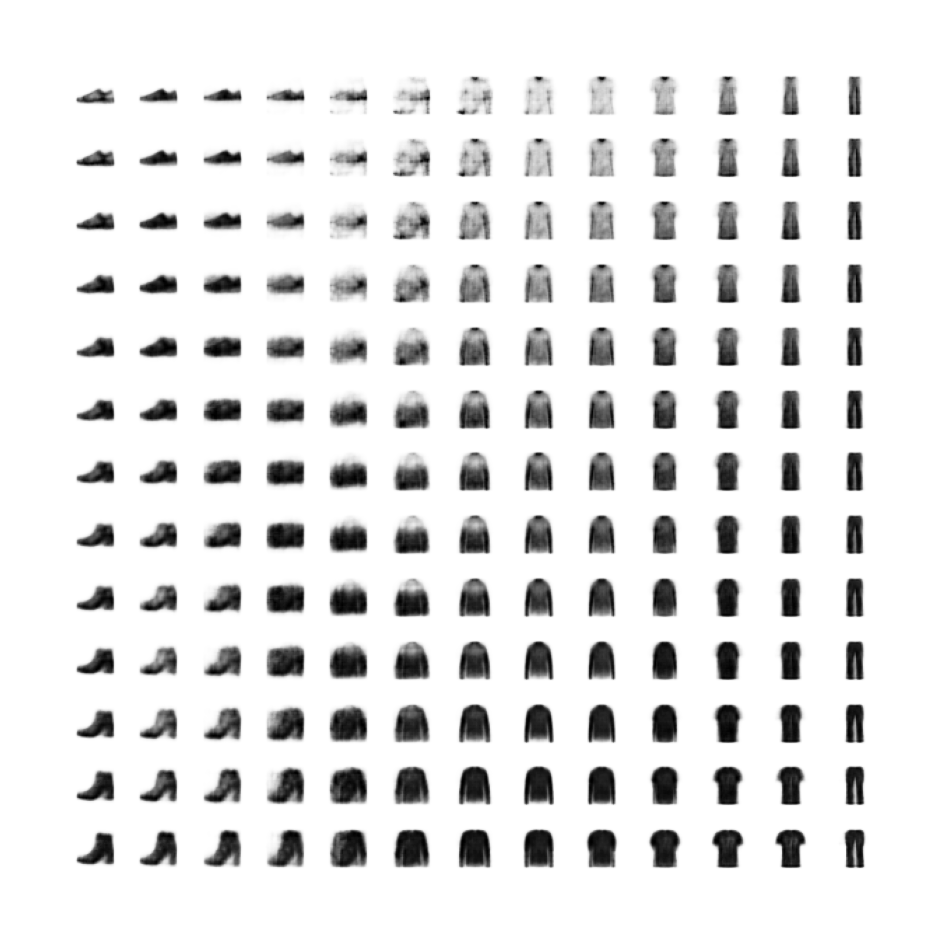

In [28]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")